# Objetivos del proyecto.

Vamos a analizar un conjunto de datos de la Universidad de Wisconsin, que contiene información sobre pacientes con posible cáncer de mama, junto con su clasificación (diagnóstico positivo o negativo).

Nuestro objetivo será entrenar y comparar diversos modelos de conjunto (ensemble models) para evaluar su desempeño.

Dado que este es un problema de diagnóstico médico, priorizaremos la métrica de recall de la clase positiva ('Malignant'), definida como: $$Recall_{Malignant}=\frac{True positives}{True positives + False Negatives},$$ ya que tiene más importancia detectar todos los posibles casos de cancer aunque esto nos lleve a dar algún falso positivo. Esta métrica se suele llamar sensibilidad en un contexto estadístico clásico.

_Es importante notar que en la práctica clínica moderna, el sobrediagnóstico del cáncer de mama es un tema muy importante. Detectar un cáncer que nunca habría causado síntomas o problemas en la vida de la paciente puede llevar a tratamientos innecesarios. De hecho, el sobrediagnóstico es actualmente uno de los principales inconvenientes de la práctica extendida de mamografías. Para más información, véase el artículo:  https://pmc.ncbi.nlm.nih.gov/articles/PMC5365181/#:~:text=Overdiagnosis%20(overdetection)%20of%20BC%20from,side%20of%20population%20breast%20screening._

En este proyecto, no solo nos interesa la precisión del modelo con respecto a métricas estándar, sino que también es fundamental evaluar su interpretabilidad. En sectores como la salud (y en áreas financieras como la concesión de préstamos hipotecarios), es indispensable entender por qué un modelo toma ciertas decisiones. Para lograrlo, utilizaremos la técnica de **Shapley Values**, que permite explicar la contribución de cada variable en las predicciones. Además, exploraremos otras técnicas complementarias para mejorar el análisis de las decisiones del modelo.

# Paquetes

En esta sección simplemente cargaremos todos los paquetes necesarios para llevar a cabo el análisis.

In [83]:
# Load libraries

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Load sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

from auxiliary_functions import (
    violin_plotter, 
    swarm_plotter, 
    get_feature_importances, 
    evaluate_models, 
    evaluate_multiple_models, 
    multiple_cross_val_confusions, 
    cross_val_confusion,
    perform_random_search
)



import shap
shap.initjs()

import warnings
warnings.filterwarnings('ignore')

ImportError: cannot import name 'perform_random_search' from 'auxiliary_functions' (c:\Users\adrian\Desktop\MasterML\Segundo_Cuatri\AAII\PEC1\auxiliary_functions.py)

# Cargando y explicando el dataset

A continuación cargamos el dataset y sus metadatos para analizarlo.

In [22]:
from ucimlrepo import fetch_ucirepo 
  

breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 

X = breast_cancer_wisconsin_diagnostic.data.features 
y = breast_cancer_wisconsin_diagnostic.data.targets 

print(breast_cancer_wisconsin_diagnostic.metadata) 
   
print(breast_cancer_wisconsin_diagnostic.variables) 

df = pd.concat([X, y], axis=1)
df['Diagnosis']=df['Diagnosis'].map({'M': 1, 'B': 0})

{'uci_id': 17, 'name': 'Breast Cancer Wisconsin (Diagnostic)', 'repository_url': 'https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic', 'data_url': 'https://archive.ics.uci.edu/static/public/17/data.csv', 'abstract': 'Diagnostic Wisconsin Breast Cancer Database.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 569, 'num_features': 30, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Diagnosis'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1993, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5DW2B', 'creators': ['William Wolberg', 'Olvi Mangasarian', 'Nick Street', 'W. Street'], 'intro_paper': {'ID': 230, 'type': 'NATIVE', 'title': 'Nuclear feature extraction for breast tumor diagnosis', 'authors': 'W. Street, W. Wolberg, O. Mangasarian', 'venue': 'Electronic imaging', 'year': 1993, 'journal': None, 'DOI': '1

Puesto que los metadatos no contienen demasiada información, vamos a explicar un poco las caracterisitcas de este conjunto de datos. Los detalles que se presentan a continuación pueden encontrarse en:https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic.

# Conjunto de Datos: Breast Cancer Wisconsin (Diagnostic)

El conjunto de datos **Breast Cancer Wisconsin (Diagnostic)** contiene información derivada de imágenes digitalizadas de aspiraciones con aguja fina (**FNA**) de masas mamarias.  
Cada instancia representa características de los núcleos celulares presentes en la imagen.

## Columnas del Conjunto de Datos

### Identificación y Diagnóstico
- **ID**: Número de identificación del paciente.
- **Diagnóstico**: Clasificación del tumor, donde **"M"** indica maligno y **"B"** indica benigno.

### Características de los Núcleos Celulares
Para cada núcleo celular, se calcularon **10 características reales**:

1. **Radio**: Promedio de las distancias desde el centro hasta los puntos en el perímetro.
2. **Textura**: Desviación estándar de los valores de escala de grises.
3. **Perímetro**: Longitud del perímetro del núcleo.
4. **Área**: Área del núcleo.
5. **Suavidad**: Variación local en las longitudes del radio.
6. **Compacidad**: $ \text{Perímetro}^2 / \text{Área} - 1.0 .$
7. **Concavidad**: Severidad de las porciones cóncavas del contorno.
8. **Puntos cóncavos**: Número de porciones cóncavas del contorno.
9. **Simetría**: Simetría del núcleo.
10. **Dimensión fractal**: "Aproximación de la línea de costa" - 1.

### Valores Calculados para Cada Característica
Para cada una de estas 10 características, se calcularon **tres valores**:

- **Media**: Valor promedio de la característica.  
- **Error estándar**: Desviación estándar de la característica.  
- **Peor valor**: Mayor valor observado (promedio de los tres valores más grandes).  

Esto da lugar a un total de **30 columnas de características** en el conjunto de datos.

### Ejemplo de Columnas en el Dataset

| Tipo | Radio | Textura | Perímetro |
|------|-------|---------|-----------|
| **Media** | `radius_mean` | `texture_mean` | `perimeter_mean` |
| **Error estándar** | `radius_se` | `texture_se` | `perimeter_se` |
| **Peor valor** | `radius_worst` | `texture_worst` | `perimeter_worst` |

Y así sucesivamente para las demás características.

Puesto que queda mucho más claro tener los nombres con _mean _se y _worst en lugar de 1 2 y 3, los sustituimos a continuación.


In [23]:
df.columns = df.columns.str.replace('1', '_mean').str.replace('2', '_se').str.replace('3', '_worst')
print(df.shape)
df.head()


(569, 31)


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst,Diagnosis
0,17.99,10.38,122.80,1001.0,0.118,0.278,0.300,0.147,0.242,0.079,...,17.33,184.60,2019.0,0.162,0.666,0.712,0.265,0.460,0.119,1
1,20.57,17.77,132.90,1326.0,0.085,0.079,0.087,0.070,0.181,0.057,...,23.41,158.80,1956.0,0.124,0.187,0.242,0.186,0.275,0.089,1
2,19.69,21.25,130.00,1203.0,0.110,0.160,0.197,0.128,0.207,0.060,...,25.53,152.50,1709.0,0.144,0.424,0.450,0.243,0.361,0.088,1
3,11.42,20.38,77.58,386.1,0.142,0.284,0.241,0.105,0.260,0.097,...,26.50,98.87,567.7,0.210,0.866,0.687,0.258,0.664,0.173,1
4,20.29,14.34,135.10,1297.0,0.100,0.133,0.198,0.104,0.181,0.059,...,16.67,152.20,1575.0,0.137,0.205,0.400,0.163,0.236,0.077,1


Vamos también a guardar los subconjuntos de columnas en variables para usarlas durante el resto del proyecto.

In [24]:
mean_columns = [col for col in df.columns if col.endswith('_mean')]
se_columns = [col for col in df.columns if col.endswith('_se')]
worst_columns = [col for col in df.columns if col.endswith('_worst')]
features=mean_columns+se_columns+worst_columns

target='Diagnosis'

# Fase preprocesado

## Estadistica basica

In [25]:
pd.set_option('display.precision', 3)
df.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst,Diagnosis
count,569.000,569.000,569.000,569.000,569.000,569.000,569.000,569.000,569.000,569.000,...,569.000,569.000,569.000,569.000,569.000,569.000,569.000,569.000,569.000,569.000
mean,14.127,19.290,91.969,654.889,0.096,0.104,0.089,0.049,0.181,0.063,...,25.677,107.261,880.583,0.132,0.254,0.272,0.115,0.290,0.084,0.373
std,3.524,4.301,24.299,351.914,0.014,0.053,0.080,0.039,0.027,0.007,...,6.146,33.603,569.357,0.023,0.157,0.209,0.066,0.062,0.018,0.484
min,6.981,9.710,43.790,143.500,0.053,0.019,0.000,0.000,0.106,0.050,...,12.020,50.410,185.200,0.071,0.027,0.000,0.000,0.157,0.055,0.000
25%,11.700,16.170,75.170,420.300,0.086,0.065,0.030,0.020,0.162,0.058,...,21.080,84.110,515.300,0.117,0.147,0.115,0.065,0.250,0.071,0.000
50%,13.370,18.840,86.240,551.100,0.096,0.093,0.062,0.034,0.179,0.062,...,25.410,97.660,686.500,0.131,0.212,0.227,0.100,0.282,0.080,0.000
75%,15.780,21.800,104.100,782.700,0.105,0.130,0.131,0.074,0.196,0.066,...,29.720,125.400,1084.000,0.146,0.339,0.383,0.161,0.318,0.092,1.000
max,28.110,39.280,188.500,2501.000,0.163,0.345,0.427,0.201,0.304,0.097,...,49.540,251.200,4254.000,0.223,1.058,1.252,0.291,0.664,0.207,1.000


In [26]:
# class distribution
df.groupby('Diagnosis').size()

Diagnosis
0    357
1    212
dtype: int64

### train test split

Vamos a dividir nuestro conjunto de datos en entrenamiento y test antes de la visualización y análisis exploratorio. Aunque podríamos hacerlo después, he decidido hacerlo en este punto porque utilizaré las visualizaciones y el análisis de correlaciones para una selección preliminar de variables. Al hacerlo antes, evitamos el data leakage, es decir, la contaminación del conjunto de entrenamiento con información del test, lo que garantizará que cualquier insight obtenido provenga únicamente de los datos con los que entrenaremos el modelo.

Dado que, según la descripción de los datos, es probable que existan altas correlaciones entre muchas variables, este análisis debe realizarse con el apoyo de un experto en el dominio (en este caso, un oncólogo especializado en cáncer de mama). La razón es que, aunque algunas características estén altamente correlacionadas, pueden capturar matices clínicos distintos que queramos preservar. Además, en ciertos casos, conservar variables redundantes puede ser útil para mejorar la robustez del modelo frente a la pérdida de datos. Un ejemplo clásico es la medición de la presión arterial: si tenemos la presión arterial sistólica (PAS), la diastólica (PAD) y la presión de pulso (PAS - PAD), eliminar una de ellas por alta correlación podría hacer que el modelo sea menos resiliente si alguna medición estuviera ausente o fuera errónea.

Si bien la presencia de correlaciones no afecta el poder predictivo de los modelos que utilizaremos, sí influye en su interpretabilidad. En particular, en algoritmos como los bosques aleatorios, la importancia de las variables (feature importance) puede verse distorsionada, ya que el modelo tiende a seleccionar aleatoriamente una de entre varias características altamente correlacionadas, subestimando la relevancia real de estas variables.

Por todas estas razones, optamos por realizar la división antes del análisis exploratorio. Esto nos permitirá trabajar con una muestra representativa del conjunto de entrenamiento y garantizar que cualquier selección de variables o transformación realizada se base exclusivamente en los datos disponibles para el entrenamiento del modelo, evitando sesgos y fugas de información.

In [27]:
X_train, X_test, y_train, y_test= train_test_split(df[features],df[target],test_size=0.2)

In [28]:
scaler= StandardScaler()

df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)


X_train_scaled = pd.DataFrame(scaler.fit_transform(df_train[features]), columns=features, index=df_train.index) 
X_test_scaled = pd.DataFrame(scaler.transform(df_test[features]), columns=features, index=df_test.index)  


# Reconstruct scaled df_train
df_train_scaled = pd.concat([X_train_scaled, y_train], axis=1)
df_test_scaled= pd.concat([X_test_scaled, y_test], axis=1)

print(X_train_scaled.shape, y_train.shape)
print(X_test_scaled.shape, y_test.shape)

(455, 30) (455,)
(114, 30) (114,)


## Visualización

In [29]:
""" palette = {1: "blue", 0: "orange"}


fig, axes = plt.subplots(3, 2, figsize=(18, 18)) 

# List of feature sets for each row (customize as needed)
feature_groups = [
    mean_columns,  # Row 1, Left: Mean Features
    se_columns,    # Row 2, Left: SE Features
    worst_columns  # Row 3, Left: Worst Features
]

for i, ax_row in enumerate(axes):

    violin_plotter(df, feature_groups[i], ax=ax_row[0])
    ax_row[0].set_title(f"Violin Plot Without Split - {i+1}")

    violin_plotter(df, feature_groups[i], split_column="Diagnosis", palette=palette, ax=ax_row[1])
    ax_row[1].set_title(f"Violin Plot Split by Diagnosis - {i+1}")


plt.tight_layout()
plt.show()
 """

' palette = {1: "blue", 0: "orange"}\n\n\nfig, axes = plt.subplots(3, 2, figsize=(18, 18)) \n\n# List of feature sets for each row (customize as needed)\nfeature_groups = [\n    mean_columns,  # Row 1, Left: Mean Features\n    se_columns,    # Row 2, Left: SE Features\n    worst_columns  # Row 3, Left: Worst Features\n]\n\nfor i, ax_row in enumerate(axes):\n\n    violin_plotter(df, feature_groups[i], ax=ax_row[0])\n    ax_row[0].set_title(f"Violin Plot Without Split - {i+1}")\n\n    violin_plotter(df, feature_groups[i], split_column="Diagnosis", palette=palette, ax=ax_row[1])\n    ax_row[1].set_title(f"Violin Plot Split by Diagnosis - {i+1}")\n\n\nplt.tight_layout()\nplt.show()\n '

In [30]:
""" fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Ajusté la altura también

feature_groups = [
    mean_columns,
    se_columns,
    worst_columns
]

for i, ax in enumerate(axes):
    swarm_plotter(df, feature_groups[i], split_column="Diagnosis", ax=ax, palette=sns.color_palette() )
    ax.set_title(f"Violin Plot Split by Diagnosis - {i+1}")

plt.tight_layout()
plt.show()  """

' fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Ajusté la altura también\n\nfeature_groups = [\n    mean_columns,\n    se_columns,\n    worst_columns\n]\n\nfor i, ax in enumerate(axes):\n    swarm_plotter(df, feature_groups[i], split_column="Diagnosis", ax=ax, palette=sns.color_palette() )\n    ax.set_title(f"Violin Plot Split by Diagnosis - {i+1}")\n\nplt.tight_layout()\nplt.show()  '

## Correlaciones

Vamos a echar un vistazo a las correlaciones entre variables. Simplemente por los nombres de las variables ya podemos esperar correlaciones altas, pero debemos confirmar nuestras sospechas.

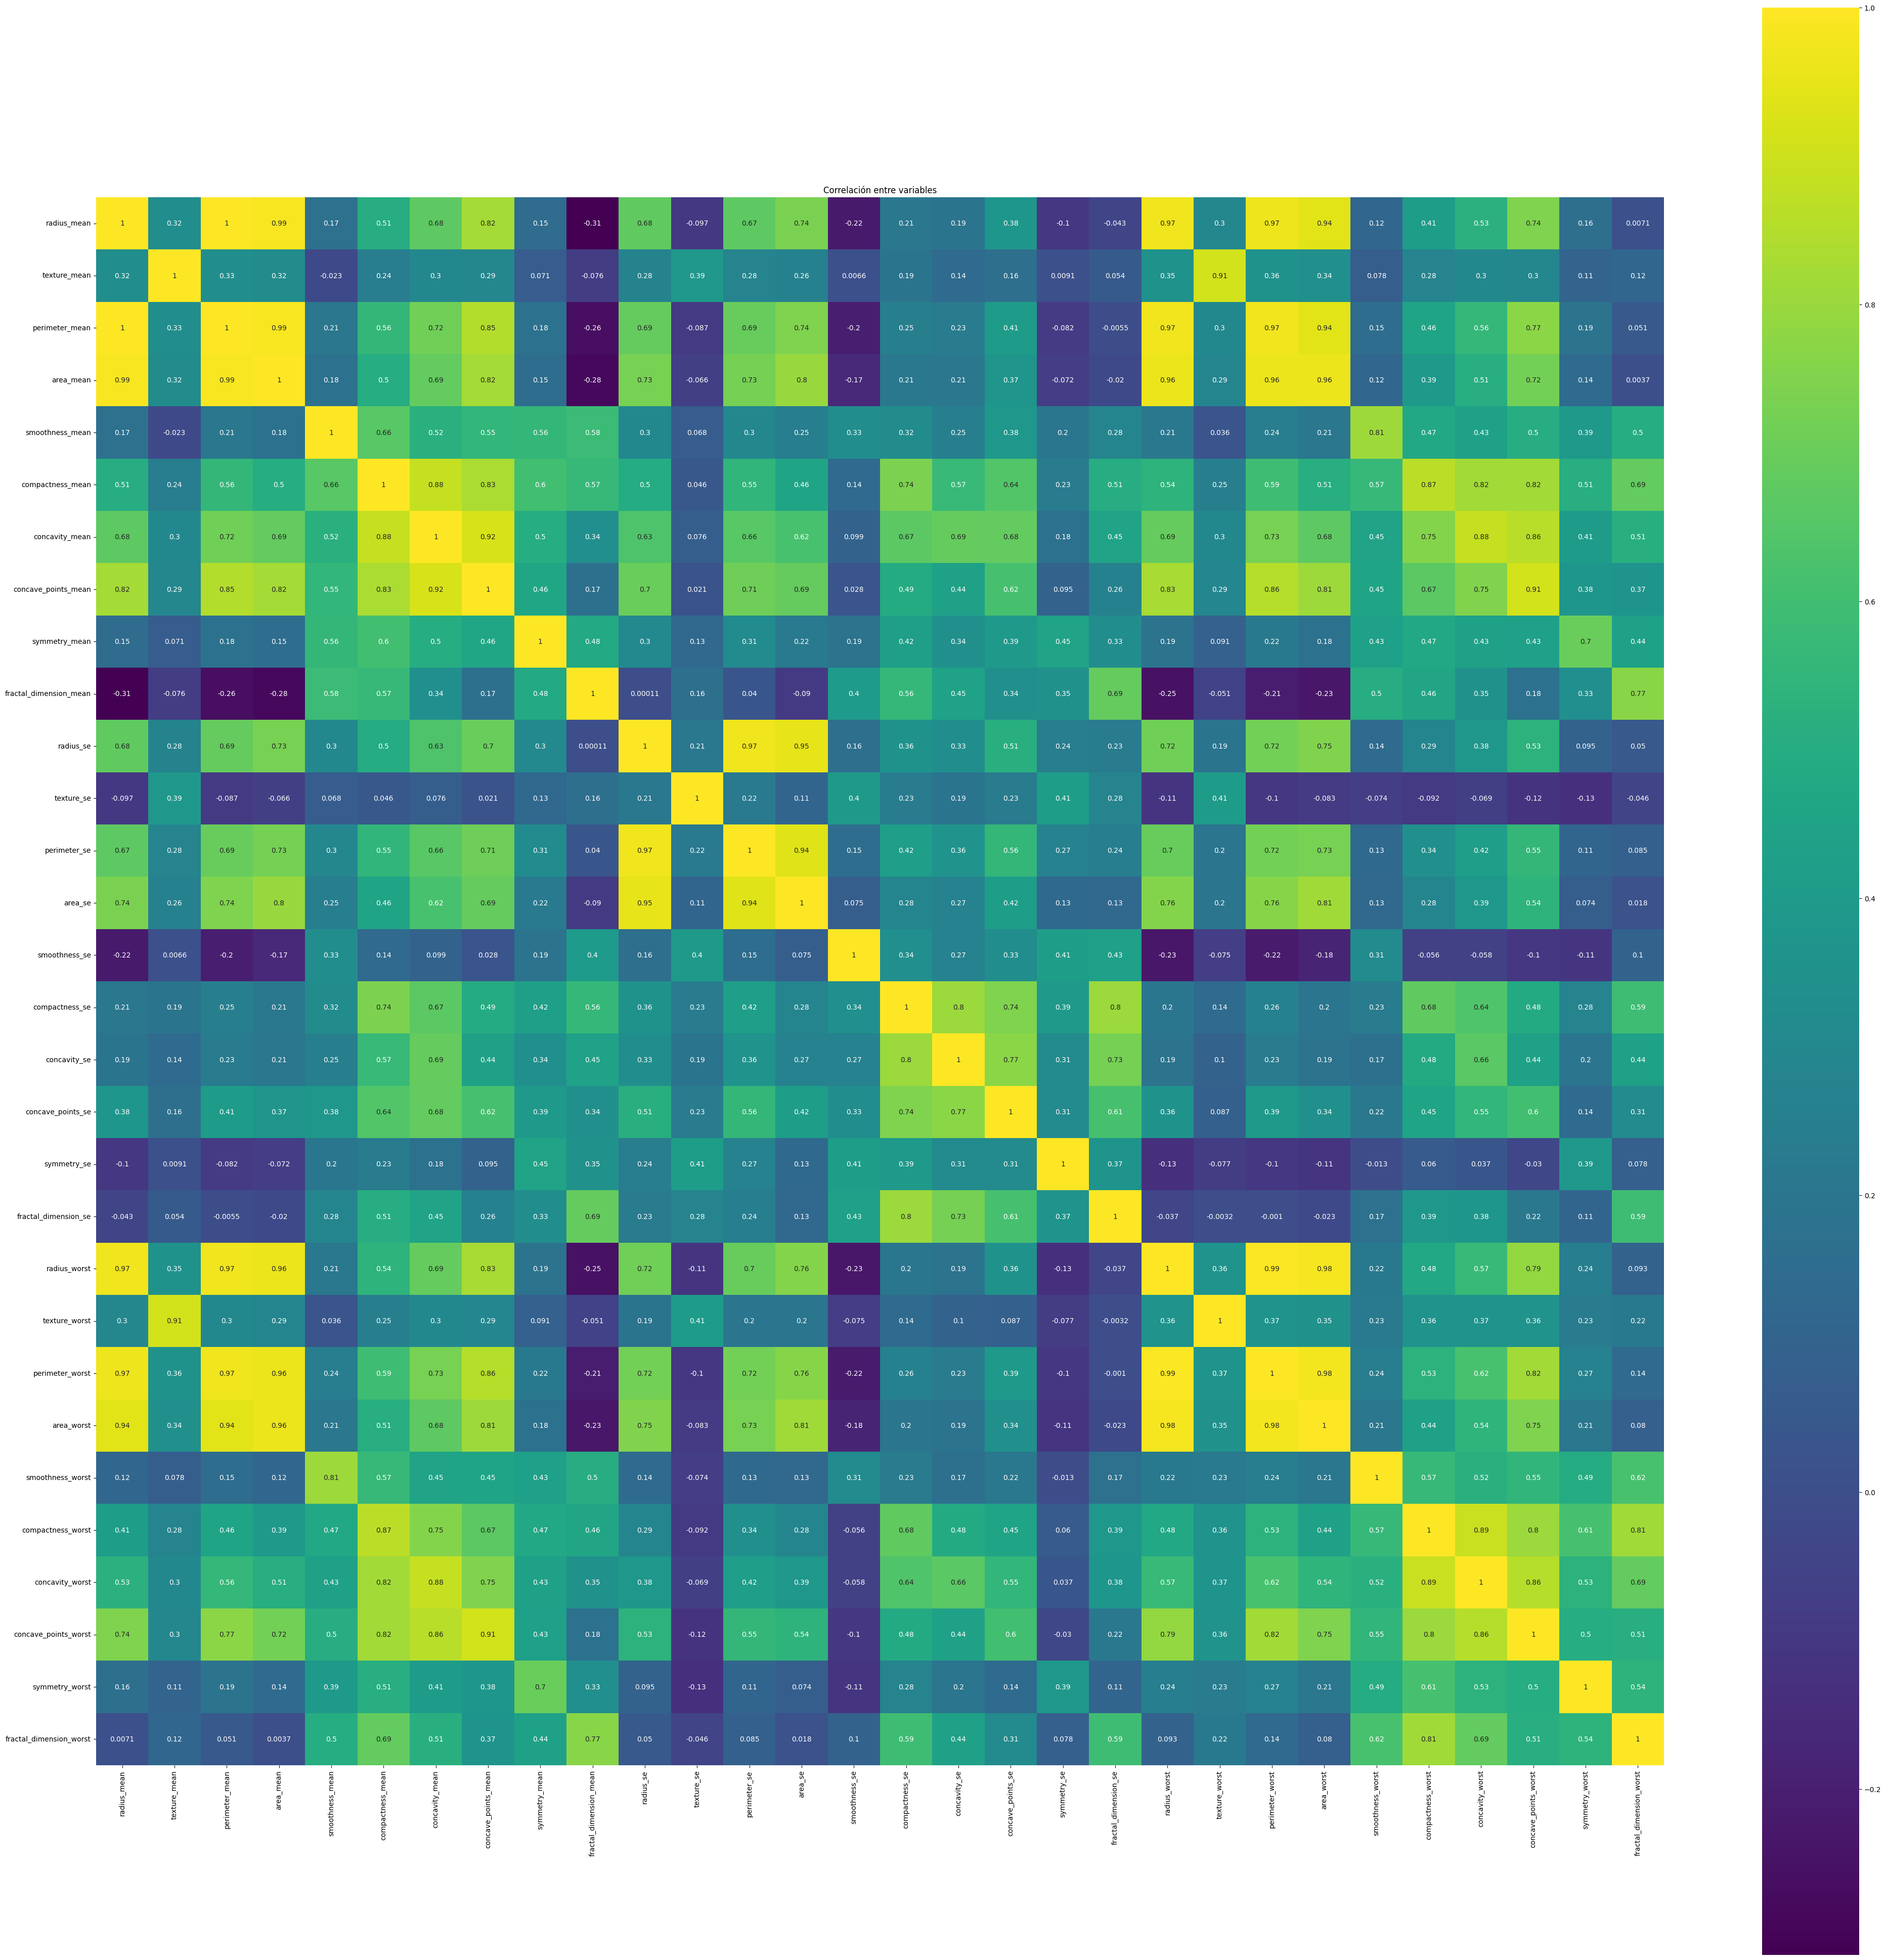

In [31]:
correlation = df[features].corr()
plt.figure(figsize=(50,50))
ax = sns.heatmap(correlation, vmax=1, square=True, annot = True, cmap = 'viridis')
plt.title('Correlación entre variables')
plt.show()

Como esperábamos, tenemos bloques altamente correlacionados:

- **Bloque 1**:
  - `radius_mean`
  - `perimeter_mean`
  - `area_mean`

- **Bloque 2**:
  - `compactness_mean`
  - `concavity_mean`
  - `concave_points_mean`

- **Bloque 3**:
  - `radius_se`
  - `perimeter_se`
  - `area_se`

- **Bloque 4**:
  - `compactness_se`
  - `concavity_se`
  - `concave_points_se`

- **Bloque 5**:
  - `radius_worst`
  - `perimeter_worst`
  - `area_worst`

- **Bloque 6**:
  - `compactness_worst`
  - `concavity_worst`
  - `concave_points_worst`

También tenemos **alta correlación entre los bloques 1 y 5**.


Vamos a guardar estos bloques en un diccionario para poder hacer más visualizaciones.

In [32]:
corr_blocks = {
    "block_mean_area": ["radius_mean", "perimeter_mean", "area_mean"],
    "block_mean_concav": ["compactness_mean", "concavity_mean", "concave_points_mean"],
    "block_se_area": ["radius_se", "perimeter_se", "area_se"],
    "block_se_concav": ["compactness_se", "concavity_se", "concave_points_se"],
    "block_worst_area": ["radius_worst", "perimeter_worst", "area_worst"],
    "block_worst_compact": ["compactness_worst", "concavity_worst", "concave_points_worst"],
}

A continuación presentamos unas gráficas donde en la diagonal vemos la densidad de la variable (dibujada con un KDE), en la mitad superior de la matriz vemos un scatter plot de una variable contra la otra y en la mitad interior un KDE de las dos variables conjuntas para hacernos una idea de su distribución.

In [33]:
""" for block_name, features_corr in corr_blocks.items():
    g = sns.PairGrid(df_train_scaled[features_corr], diag_sharey=False)
    g.map_lower(sns.kdeplot, cmap="Blues_d")
    g.map_upper(plt.scatter)
    g.map_diag(sns.kdeplot, lw=3)
    g.fig.suptitle(block_name, fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show() """


' for block_name, features_corr in corr_blocks.items():\n    g = sns.PairGrid(df_train_scaled[features_corr], diag_sharey=False)\n    g.map_lower(sns.kdeplot, cmap="Blues_d")\n    g.map_upper(plt.scatter)\n    g.map_diag(sns.kdeplot, lw=3)\n    g.fig.suptitle(block_name, fontsize=16, y=1.02)\n    plt.tight_layout()\n    plt.show() '

Esto nos permite confirmar con más certeza que las altas correlaciones no son casos de distribuciones patológicas si no que son variables altamente colineales.

A continuación selecciono una variable de cada uno de los bloques de alta correlación, para ello utilizo las gráficas de violín y enjambre presentadas anteriormente. De cada bloque elijo la que parece presentar mejor separación entre casos de tumores benignos y malignos.

In [34]:
drop_list1 = ['perimeter_mean','radius_mean','compactness_mean','concave_points_mean','radius_se','perimeter_se','radius_worst','perimeter_worst','compactness_worst','concave_points_worst','compactness_se','concave_points_se','texture_worst']
df_train_scaled_filtered = df_train_scaled.drop(drop_list1,axis = 1 ) 
df_train_scaled_filtered.head()


,texture_mean,area_mean,smoothness_mean,concavity_mean,symmetry_mean,fractal_dimension_mean,texture_se,area_se,smoothness_se,concavity_se,symmetry_se,fractal_dimension_se,area_worst,smoothness_worst,concavity_worst,symmetry_worst,fractal_dimension_worst,Diagnosis
287,-1.430,-0.410,-1.884,-0.823,-1.736,-0.989,-1.373,-0.597,-0.815,-0.515,-0.522,-0.635,-0.547,-1.623,-0.747,-0.951,-0.850,0
351,-0.024,0.261,1.975,2.520,2.062,1.925,0.227,0.203,0.807,2.426,4.250,1.393,0.033,1.008,2.065,2.129,1.239,1
137,-0.907,-0.731,0.008,-0.668,-0.283,-0.579,-0.391,-0.597,-0.673,-0.592,-0.665,-0.826,-0.744,-0.602,-0.642,-0.367,-0.938,0
261,0.861,0.744,-0.681,-0.745,-0.906,-1.384,0.214,0.062,-0.464,-0.659,-0.775,-0.830,0.552,-0.378,-0.735,-0.724,-1.084,1
532,-0.690,-0.245,-0.248,-0.886,-0.660,-0.162,-1.352,-0.502,-1.133,-0.849,-1.209,-0.784,-0.210,-0.271,-0.737,-0.161,-0.345,0


In [35]:
filtered_features = [f for f in features if f not in drop_list1]

A continuación vemos la matriz de correlaciones de las variables que hemos dejado para proceder con el análisis. Se puede ver una gran mejoría, aunque aún siguen quedando algunas variables con alta correlación.

He decidido no seguir seleccionando variables solamente con la correlación porque a continuación aplicaremos otros métodos.

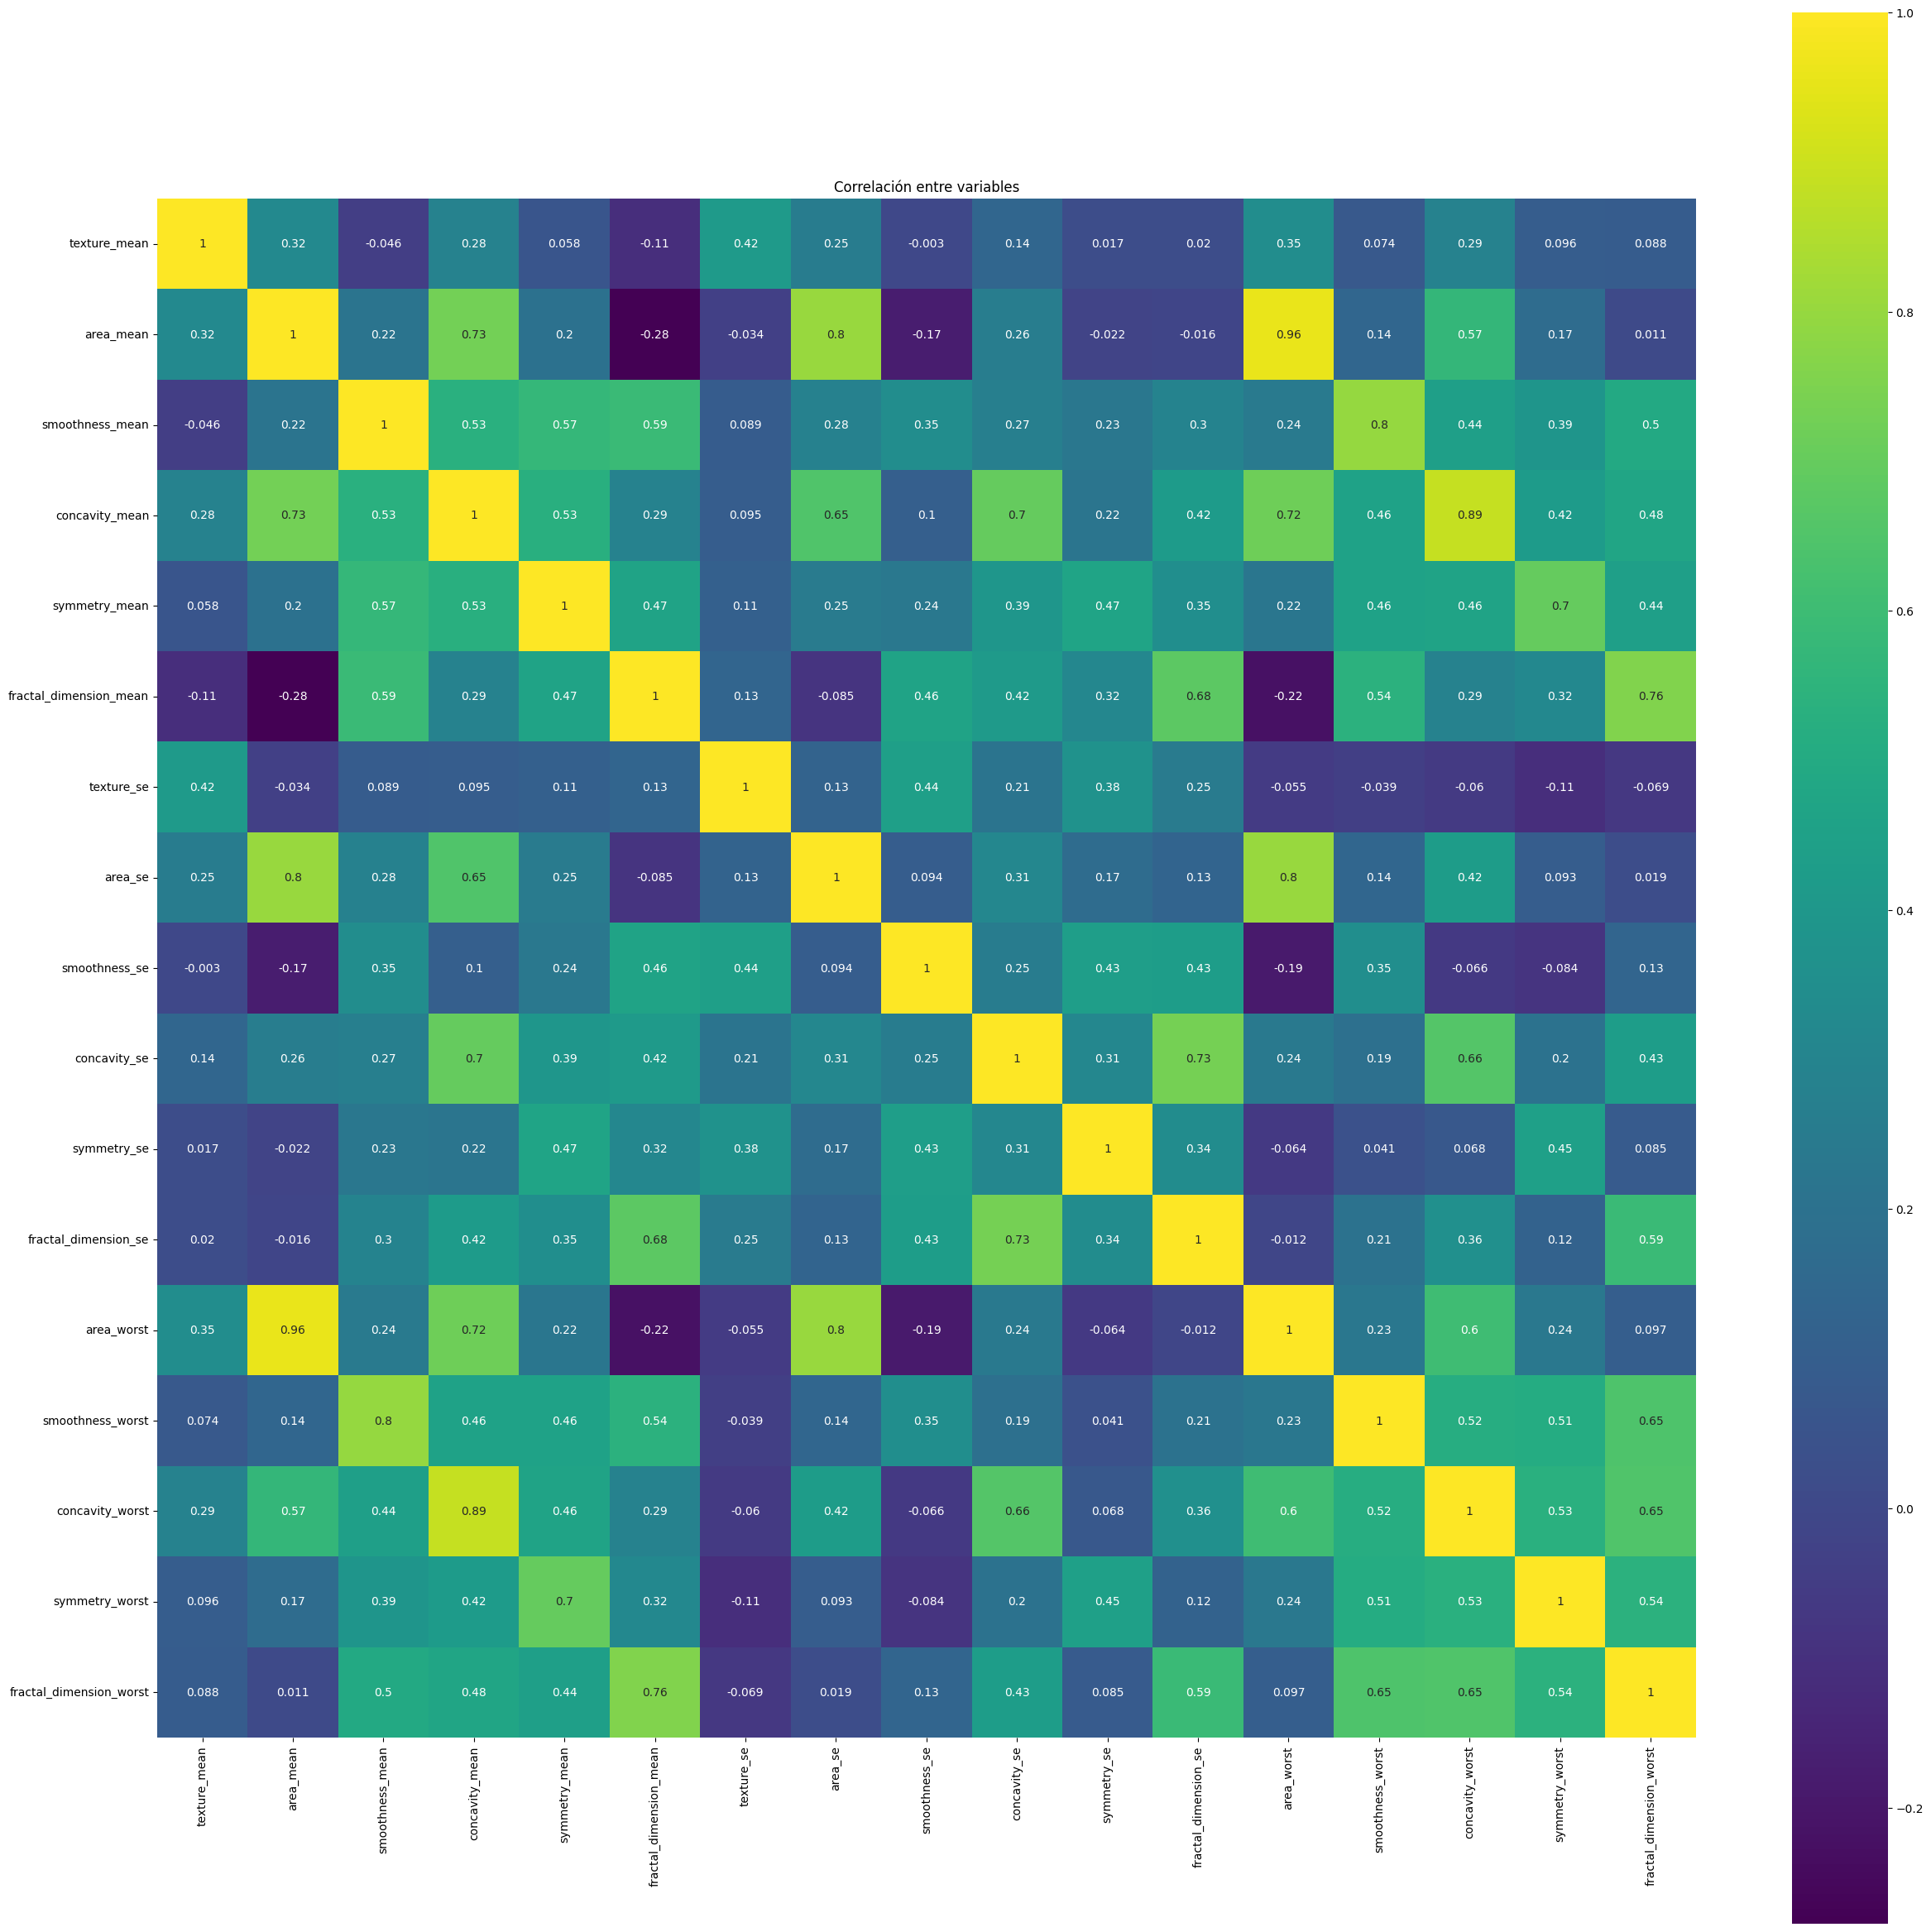

In [36]:
correlation =df_train_scaled[filtered_features].corr()
plt.figure(figsize=(30,30))
ax = sns.heatmap(correlation, vmax=1, square=True, annot = True, cmap = 'viridis')
plt.title('Correlación entre variables')
plt.show()

## Feature importance

In [37]:
X_train=df_train_scaled[features]
y_train=df_train_scaled[target]

X_train_filtered=df_train_scaled[filtered_features]
y_train_filtered=df_train_scaled[target]

Hemos llevado a cabo una preselección de variables usando simplemente las correlaciones. Uno de los objetivos de esta preselección era poder usar `feature_importances` de los bosques aleatorios. Este método nos permite averiguar que características son importantes para distinguir los casos benignos y malignos ajustando un bosque aleatorio a los datos  y viendo que características aparecen más frecuentemente en la construcción de los distintos árboles. Una frecuencia de aparición alta quiere decir que es una característica que normalmente presenta el mejor umbral de corte para distinguir entre casos positivos y negativos.

Este método puede verse afectado por la colinealidad, puesto que si dos características son colineales o altamente correladas, ambas representarán umbrales esencialmente equivalentes, por lo que podemos esperar que el algoritmo de bosques aleatorios escoja una de ellas con probabilidad uniforme (si hay dos, probabilidad $\frac{1}{2}$, si hay $n$ variables altamente colineales por pares, probabilidad aproximadamente $\frac{1}{n}$). Lo cual daría una importancia aparente mucho más baja a las variables que la que en realidad les corresponde.

Vamos a ver esto ejemplificado a continuación. Mostramos a la izquierda la media y la desviación típica (en forma de barra de error) de extraer `feature_importances` de 100 random forest, cada uno con 500 árboles, sobre e conjunto de datos de entrenamiento con todas las variables. A la derecha podemos observar lo mismo pero esta vez sobre el conjunto de datos de entrenamiento donde hemos eliminado las variables altamente correlacionadas.

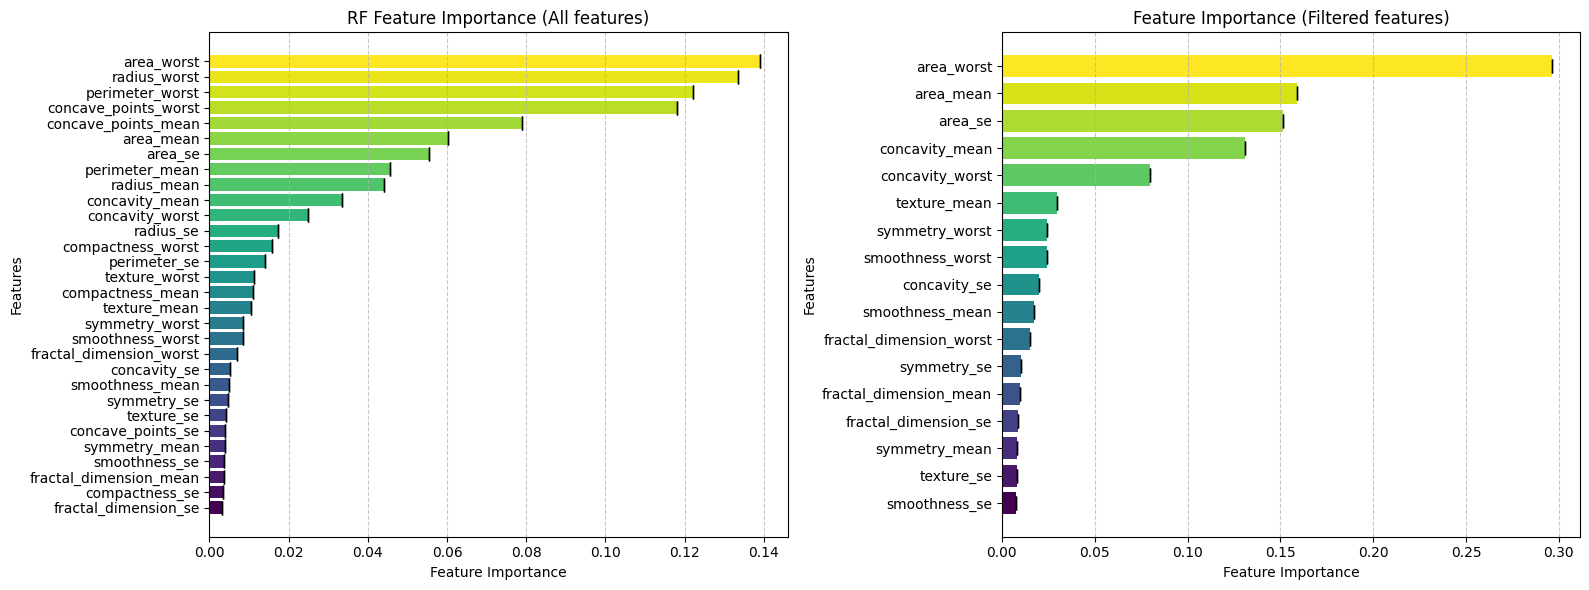

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

df_feat_imp_unfiltered, _, _ = get_feature_importances(X_train, y_train, 500, n_runs=1, ax=axes[0])
axes[0].set_title("RF Feature Importance (All features)")

df_feat_imp_filtered, _, _ = get_feature_importances(X_train_filtered, y_train_filtered, 500, n_runs=1, ax=axes[1])
axes[1].set_title("Feature Importance (Filtered features)")

plt.tight_layout()
plt.show()


Podemos ver que area worst gana mucho más protagonismo cuando hemos hecho un primer filtrado de las variables, en particular parece haber absorbido la importancia de `perimeter_worst` que es una de las variables que presentaba alta correlación con ella. 

A continuación vamos a quedarnos con las 11 variables más importantes (del conjunto filtrado) y con las 5 más importantes. Veremos el desempeño de los modelos en esos conjuntos para ver cuantas variables nos interesa retener. Posiblemente, un mayor número de variables de un mejor desempeño en todas las métricas (simplemente porque le proporcionamos más información al modelo), pero un menor numero de variables mejora la explicabilidad, por lo que quizás sea interesante sacrificar algo de desempeño. Esta decisión debería tomarse con expertos del área, pero desafortunadamente para este trabajo tendremos que intentar tomar estas decisiones solo con intuición.

In [39]:
top_11_imp_features = df_feat_imp_filtered.sort_values(by="Importance", ascending=False).head(11)["Feature"].tolist()
top_5_imp_features = df_feat_imp_filtered.sort_values(by="Importance", ascending=False).head(5)["Feature"].tolist()

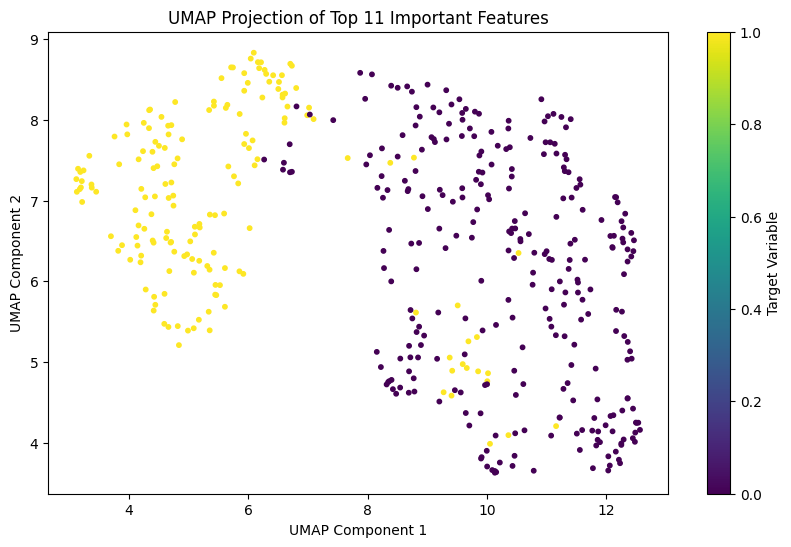

In [40]:
import umap


X_train_filtered_top11=df_train_scaled[top_11_imp_features]
y_train_filtered_top11=df_train_scaled[target]

reducer = umap.UMAP(n_components=2, random_state=42)

# Fit and transform the data to 2D
X_train_umap = reducer.fit_transform(X_train_filtered_top11)

# Plot the 2D projection with colors based on the target variable
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], c=y_train_filtered_top11, cmap='viridis', s=10)
plt.colorbar(scatter, label='Target Variable')
plt.title('UMAP Projection of Top 11 Important Features')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()


# Model training

A continuación vamos a proceder a entrenar los modelos y comprobar su desempeño usando validación cruzada. Vamos a dividir los modelos en varias categorías:

- **Voting**: Vamos a entrenar el mismo modelo (regresión logística, random forest y SVC) con dos esquemas
    - Soft: Hacemos la media de las probabilidades antes de decidir.
    - Hard: Tomamos la decisión mayoritaria.
- **Bagging**
- **Random forest y Extra trees**
- **Boosting**
- **Stacking**

In [41]:
X_train=df_train_scaled[features]
y_train=df_train_scaled[target]

X_train_filtered=df_train_scaled[filtered_features]
y_train_filtered=df_train_scaled[target]


X_train_filtered_top11=df_train_scaled[top_11_imp_features]
y_train_filtered_top11=df_train_scaled[target]

X_train_filtered_top5=df_train_scaled[top_5_imp_features]
y_train_filtered_top5=df_train_scaled[target]

In [81]:
datasets = {
    "All Features": (X_train, y_train),
    "Filtered Features": (X_train_filtered, y_train_filtered),
    "Top 11 Important": (X_train_filtered_top11, y_train_filtered_top11),
    "Top 5 Important": (X_train_filtered_top5, y_train_filtered_top5)
}


from sklearn.metrics import make_scorer, recall_score

# Custom recall scorer focusing on malignant class (1)
malignant_recall = make_scorer(recall_score, pos_label=1)

scoring = {
    'accuracy': 'accuracy',
    'recall_macro': 'recall_macro',
    'malignant_recall': malignant_recall
}


## Voting

In [43]:
from sklearn.ensemble import VotingClassifier
voting_soft = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression()),
        ('rf', RandomForestClassifier()),
        ('svc', SVC(probability=True))
    ],
    voting='soft'
)

results_df=evaluate_models(voting_soft, datasets, scoring=scoring)
results_df

,Dataset,accuracy Mean,accuracy Std,recall_macro Mean,recall_macro Std,malignant_recall Mean,malignant_recall Std
0,All Features,0.982,0.013,0.979,0.017,0.965,0.034
1,Filtered Features,0.974,0.015,0.969,0.017,0.953,0.030
2,Top 11 Important,0.976,0.016,0.972,0.017,0.959,0.024
3,Top 5 Important,0.960,0.019,0.957,0.021,0.941,0.046


Classification Report:
              precision    recall  f1-score   support

      Benign       0.98      0.99      0.98       285
   Malignant       0.98      0.96      0.97       170

    accuracy                           0.98       455
   macro avg       0.98      0.97      0.97       455
weighted avg       0.98      0.98      0.98       455



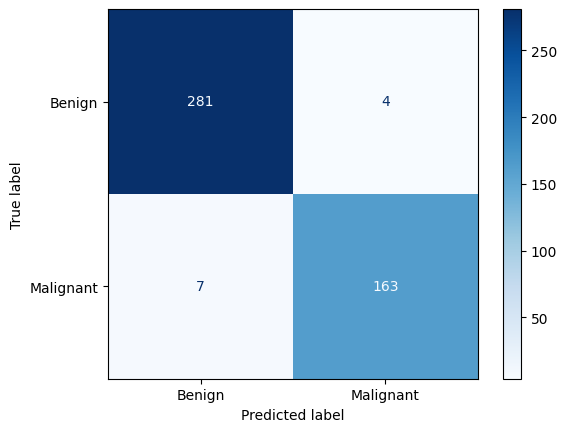

In [44]:
cross_val_confusion(voting_soft, X_train_filtered_top11, y_train_filtered_top11)


In [45]:
from sklearn.ensemble import VotingClassifier
voting_hard = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression()),
        ('rf', RandomForestClassifier()),
        ('svc', SVC(probability=True))
    ],
    voting='hard'
)

results_df=evaluate_models(voting_hard, datasets, scoring=scoring)
results_df

,Dataset,accuracy Mean,accuracy Std,recall_macro Mean,recall_macro Std,malignant_recall Mean,malignant_recall Std
0,All Features,0.982,0.011,0.978,0.016,0.959,0.035
1,Filtered Features,0.974,0.020,0.967,0.024,0.941,0.042
2,Top 11 Important,0.974,0.019,0.968,0.022,0.947,0.034
3,Top 5 Important,0.958,0.016,0.952,0.019,0.929,0.044


Classification Report:
              precision    recall  f1-score   support

      Benign       0.97      0.99      0.98       285
   Malignant       0.98      0.95      0.96       170

    accuracy                           0.97       455
   macro avg       0.98      0.97      0.97       455
weighted avg       0.97      0.97      0.97       455



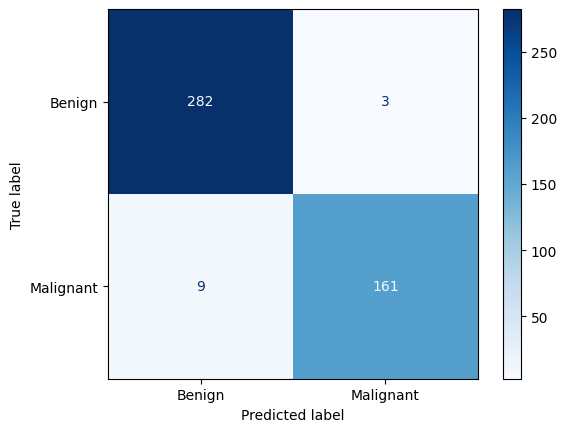

In [46]:
cross_val_confusion(voting_hard, X_train_filtered_top11, y_train_filtered_top11)

## Bagging

Vamos a aplicar bagging a árboles de decisión y regresión logísitica. Nótese, que lo aplicamos para regresión logística simplemente por una cuestión de variedad. Los modelos estables como la regresión logística no suelen beneficiarse tanto como los modelos de alta varianza (como los árboles de decisión).

A continuación citamos dos parrafos relevantes de `Elements of statistical learning`:

Not all estimators can be improved by shaking up the data like this [via bagging]. It seems that highly nonlinear estimators, such as trees, benefit the most. For bootstrapped trees, $\rho$ [the correlation of estimators] is typically small, while $\sigma^2$  [their variance] is not much larger than the variance for the original tree. On the other hand, bagging does not change linear estimates, such as the sample mean (hence its variance either); the pairwise correlation between bootstrapped means is about 50%

Note that when we bag a model, any simple structure in the model is lost. As an example, a bagged tree is no longer a tree. For interpretation of the model this is clearly a drawback. More stable procedures like nearest neighbors are typically not affected much by bagging. Unfortunately, the unstable models most helped by bagging are unstable because of the emphasis on interpretability, and this is lost in the bagging process.

In [47]:
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression

In [48]:
bagging_tree = BaggingClassifier(
    estimator=DecisionTreeClassifier(),
    n_estimators=50,  # Número de modelos en el ensamble
    random_state=42
)

results_df=evaluate_models(bagging_tree, datasets, scoring=scoring)
results_df

,Dataset,accuracy Mean,accuracy Std,recall_macro Mean,recall_macro Std,malignant_recall Mean,malignant_recall Std
0,All Features,0.941,0.027,0.937,0.024,0.924,0.035
1,Filtered Features,0.945,0.028,0.940,0.026,0.918,0.022
2,Top 11 Important,0.954,0.022,0.950,0.022,0.935,0.029
3,Top 5 Important,0.949,0.016,0.945,0.019,0.929,0.044


Classification Report:
              precision    recall  f1-score   support

      Benign       0.96      0.96      0.96       285
   Malignant       0.94      0.94      0.94       170

    accuracy                           0.95       455
   macro avg       0.95      0.95      0.95       455
weighted avg       0.95      0.95      0.95       455



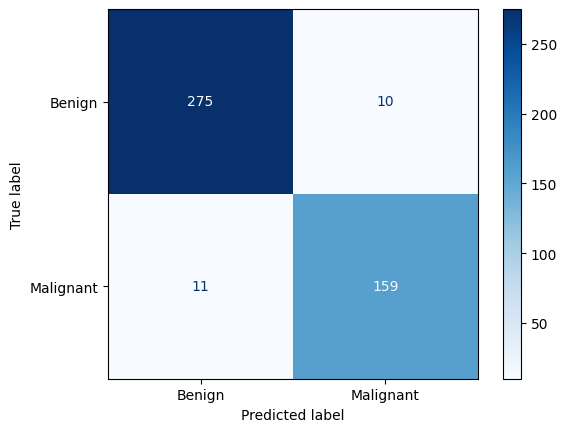

In [49]:
cross_val_confusion(bagging_tree, X_train_filtered_top11, y_train_filtered_top11)

In [50]:
bagging_LR = BaggingClassifier(
    estimator=LogisticRegression(),
    n_estimators=50,  # Número de modelos en el ensamble
    random_state=42
)

results_df=evaluate_models(bagging_LR, datasets, scoring=scoring)
results_df

,Dataset,accuracy Mean,accuracy Std,recall_macro Mean,recall_macro Std,malignant_recall Mean,malignant_recall Std
0,All Features,0.985,0.016,0.979,0.022,0.959,0.044
1,Filtered Features,0.976,0.018,0.971,0.021,0.953,0.040
2,Top 11 Important,0.978,0.016,0.973,0.018,0.953,0.030
3,Top 5 Important,0.954,0.008,0.947,0.010,0.918,0.039


Classification Report:
              precision    recall  f1-score   support

      Benign       0.97      0.99      0.98       285
   Malignant       0.99      0.95      0.97       170

    accuracy                           0.98       455
   macro avg       0.98      0.97      0.98       455
weighted avg       0.98      0.98      0.98       455



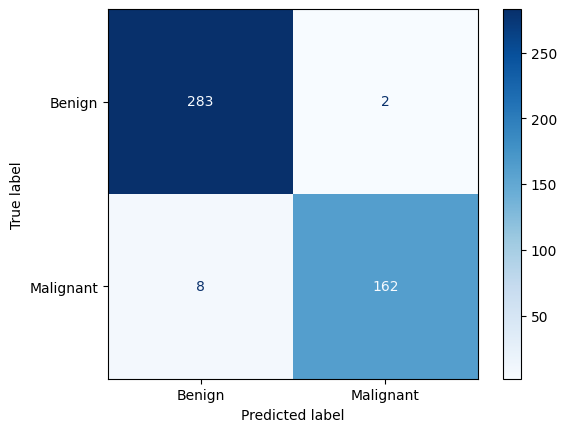

In [51]:
cross_val_confusion(bagging_LR, X_train_filtered_top11, y_train_filtered_top11)

## Random forest and extra trees

Vamos a implementar y evaluar también Random forest y Extra trees. ¿Cual es la diferencia entre estos dos modelos y bagging trees? Lo ilustramos a continuación. 

| Aspecto                    | Random Forest (Bosques Aleatorios)  | Extra Trees (Árboles Extremos)            | Bagging Trees      |
|----------------------------|-------------------------------------|-----------------------------------------|------------------------------------------|
| Modelo Base                | Árboles de Decisión                | Árboles de Decisión                     | Generalmente Árboles de Decisión         |
| Selección de Características| Subconjunto aleatorio por división| Subconjunto aleatorio por división     | Usa todas las características por división |
| Criterio de División       | Impureza Gini o Entropía           | Divisiones aleatorias                  | Impureza Gini, Entropía u otros           |
| Correlación entre Árboles   | Media                              | Baja (más aleatoriedad)                | Alta (si no se seleccionan características aleatorias) |
| Reducción de Varianza       | Alta (promedio del ensamble)      | Alta (promedio del ensamble)           | Alta (promedio del ensamble)            |
| Sesgo (Bias)                | Bajo a Medio                      | Más alto (debido a la aleatoriedad)    | Bajo a Medio                             |
| Tendencia a Sobreajuste     | Baja                              | Baja                                    | Puede ser alta si los modelos base sobreajustan |
| Robustez al Ruido           | Alta                              | Alta                                    | Media a Alta                            |


In [52]:
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

results_df=evaluate_models(rf, datasets, scoring=scoring)
results_df

,Dataset,accuracy Mean,accuracy Std,recall_macro Mean,recall_macro Std,malignant_recall Mean,malignant_recall Std
0,All Features,0.954,0.018,0.950,0.013,0.935,0.012
1,Filtered Features,0.954,0.015,0.948,0.016,0.924,0.035
2,Top 11 Important,0.965,0.011,0.962,0.010,0.953,0.024
3,Top 5 Important,0.952,0.019,0.946,0.022,0.924,0.048


Classification Report:
              precision    recall  f1-score   support

      Benign       0.97      0.97      0.97       285
   Malignant       0.95      0.95      0.95       170

    accuracy                           0.96       455
   macro avg       0.96      0.96      0.96       455
weighted avg       0.96      0.96      0.96       455



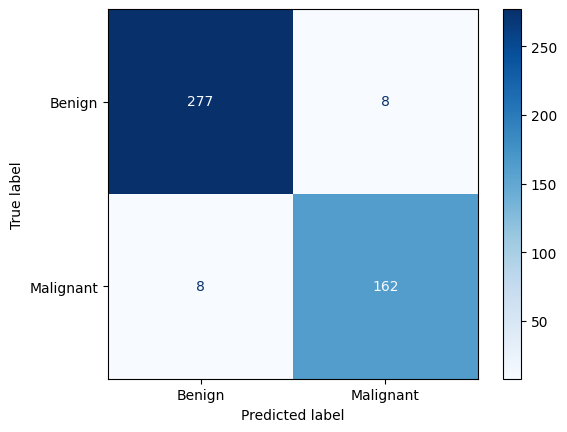

In [53]:
cross_val_confusion(rf, X_train_filtered_top11, y_train_filtered_top11)

In [54]:
et = ExtraTreesClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

results_df=evaluate_models(et, datasets, scoring=scoring)
results_df

,Dataset,accuracy Mean,accuracy Std,recall_macro Mean,recall_macro Std,malignant_recall Mean,malignant_recall Std
0,All Features,0.971,0.011,0.968,0.014,0.953,0.030
1,Filtered Features,0.965,0.018,0.958,0.022,0.929,0.044
2,Top 11 Important,0.965,0.016,0.958,0.019,0.929,0.035
3,Top 5 Important,0.952,0.024,0.946,0.029,0.924,0.061


Classification Report:
              precision    recall  f1-score   support

      Benign       0.96      0.99      0.97       285
   Malignant       0.98      0.93      0.95       170

    accuracy                           0.96       455
   macro avg       0.97      0.96      0.96       455
weighted avg       0.97      0.96      0.96       455



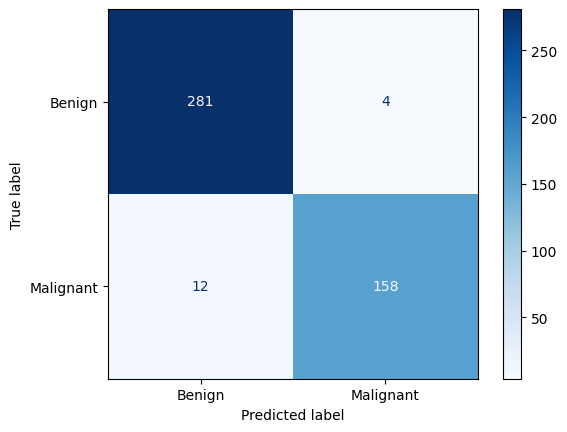

In [55]:
cross_val_confusion(et, X_train_filtered_top11, y_train_filtered_top11)

## Boosting

Mientras que bagging, random forest y extra trees presentan una estrategia común (reducir la varianza). Boosting es una estrategia con principios diferentes.

En boosting, los estimadores construidos no son independientes unos de otros si no que los construimos en serie, de tal forma que cada nuevo estimador corrija los errores de los anteriores. Esta estrategia intenta reducir el sesgo del estimador final.

Existen varias estrategias de boosting:
- Adaboost: Utiliza pesos sobre las muestras para darles prioridad, cuando el estimador actual comete errores clasificando esa muestra, se incrementa su peso para incentivar al siguiente a clasificarla correctamente. Cada estimador construido también tiene su propio peso. Al final del proceso se toma una media ponderada para la decisión final.
- Gradient boost/ Extreme gradient boost: Estos dos son estrategias del descenso del gradiente. La idea es imitar el proceso por el que ajustamos modelos como una red neuronal, pero usando árboles. Esto puede hacerse ajustando un árbol de regresión a los pseudo residuos (la forma exacta de los pseudo residuos viene dada por el gradiente de la función de pérdida) del paso anterior y añadiendoselo al estimador construido en ese paso con una tasa de aprendizaje (para clasificación es un poco más complicado). XGBoost es una implementación particular de gradient boosting altamente optimizada, que presenta poda de árboles además de penalizaciones $L^1$ y $L^2$.

In [56]:
from xgboost import XGBClassifier

In [57]:
xgb_tree = XGBClassifier(eval_metric='logloss', n_jobs=-1)

results_df=evaluate_models(xgb_tree, datasets, scoring=scoring)
results_df

,Dataset,accuracy Mean,accuracy Std,recall_macro Mean,recall_macro Std,malignant_recall Mean,malignant_recall Std
0,All Features,0.958,0.032,0.955,0.030,0.941,0.037
1,Filtered Features,0.963,0.020,0.957,0.025,0.935,0.051
2,Top 11 Important,0.965,0.019,0.961,0.021,0.947,0.034
3,Top 5 Important,0.958,0.019,0.952,0.021,0.929,0.040


Classification Report:
              precision    recall  f1-score   support

      Benign       0.97      0.98      0.97       285
   Malignant       0.96      0.95      0.95       170

    accuracy                           0.96       455
   macro avg       0.96      0.96      0.96       455
weighted avg       0.96      0.96      0.96       455



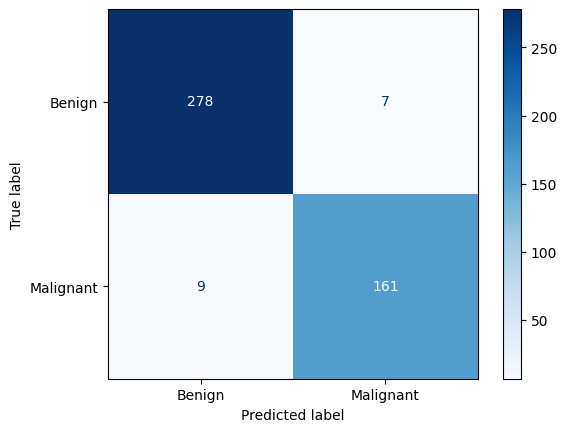

In [58]:
cross_val_confusion(xgb_tree, X_train_filtered_top11, y_train_filtered_top11)

In [59]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

logistic_base = LogisticRegression()

adaboost_logistic = AdaBoostClassifier(
    estimator=logistic_base,
    n_estimators=50,
    algorithm="SAMME.R",
    random_state=42
)

results_df=evaluate_models(adaboost_logistic, datasets, scoring=scoring)
results_df


,Dataset,accuracy Mean,accuracy Std,recall_macro Mean,recall_macro Std,malignant_recall Mean,malignant_recall Std
0,All Features,0.976,0.015,0.972,0.020,0.959,0.044
1,Filtered Features,0.974,0.018,0.971,0.022,0.959,0.040
2,Top 11 Important,0.982,0.015,0.980,0.014,0.971,0.019
3,Top 5 Important,0.949,0.009,0.942,0.009,0.912,0.042


Classification Report:
              precision    recall  f1-score   support

      Benign       0.98      0.99      0.99       285
   Malignant       0.98      0.97      0.98       170

    accuracy                           0.98       455
   macro avg       0.98      0.98      0.98       455
weighted avg       0.98      0.98      0.98       455



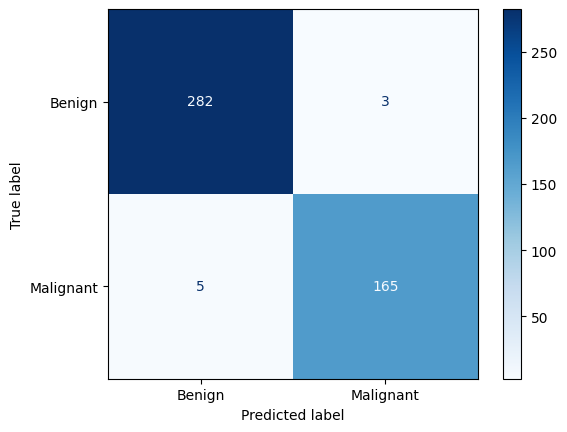

In [60]:
cross_val_confusion(adaboost_logistic, X_train_filtered_top11, y_train_filtered_top11)

## Staking

In [61]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

stack1 = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ],
    final_estimator=LogisticRegression(),
    cv=5
)

results_df=evaluate_models(stack1, datasets, scoring=scoring)
results_df

,Dataset,accuracy Mean,accuracy Std,recall_macro Mean,recall_macro Std,malignant_recall Mean,malignant_recall Std
0,All Features,0.952,0.020,0.948,0.017,0.935,0.022
1,Filtered Features,0.956,0.016,0.953,0.013,0.941,0.026
2,Top 11 Important,0.963,0.009,0.959,0.010,0.947,0.029
3,Top 5 Important,0.958,0.020,0.952,0.022,0.929,0.035


Classification Report:
              precision    recall  f1-score   support

      Benign       0.97      0.97      0.97       285
   Malignant       0.95      0.95      0.95       170

    accuracy                           0.96       455
   macro avg       0.96      0.96      0.96       455
weighted avg       0.96      0.96      0.96       455



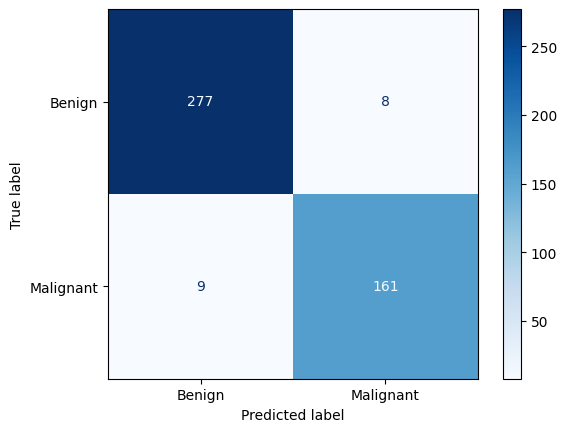

In [62]:
cross_val_confusion(stack1, X_train_filtered_top11, y_train_filtered_top11)

In [63]:
from sklearn.linear_model import RidgeClassifier

stack2 = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('logreg', LogisticRegression(max_iter=1000)),
        ('et', ExtraTreesClassifier(n_estimators=100, random_state=42))
    ],
    final_estimator=RidgeClassifier(),
    cv=5
)

results_df=evaluate_models(stack2, datasets, scoring=scoring)
results_df

,Dataset,accuracy Mean,accuracy Std,recall_macro Mean,recall_macro Std,malignant_recall Mean,malignant_recall Std
0,All Features,0.982,0.015,0.978,0.021,0.959,0.044
1,Filtered Features,0.974,0.018,0.968,0.021,0.947,0.039
2,Top 11 Important,0.976,0.016,0.970,0.021,0.947,0.043
3,Top 5 Important,0.956,0.018,0.951,0.022,0.929,0.051


Classification Report:
              precision    recall  f1-score   support

      Benign       0.97      0.99      0.98       285
   Malignant       0.99      0.95      0.97       170

    accuracy                           0.98       455
   macro avg       0.98      0.97      0.97       455
weighted avg       0.98      0.98      0.98       455



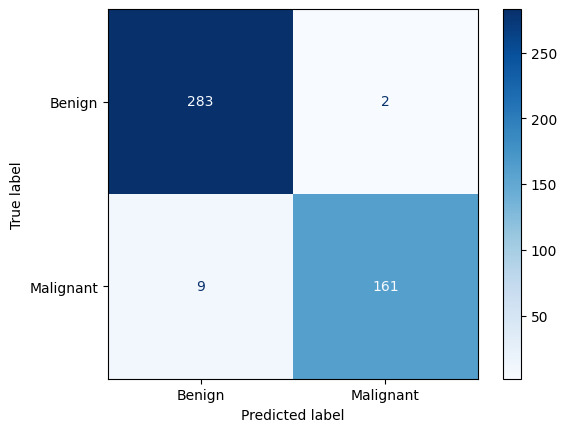

In [64]:
cross_val_confusion(stack2, X_train_filtered_top11, y_train_filtered_top11)

In [65]:
stack3 = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier()),
        ('ada', AdaBoostClassifier()),
        ('gb', GradientBoostingClassifier())
    ],
    final_estimator=LogisticRegression(),
    cv=5
)
results_df=evaluate_models(stack3, datasets, scoring=scoring)
results_df

,Dataset,accuracy Mean,accuracy Std,recall_macro Mean,recall_macro Std,malignant_recall Mean,malignant_recall Std
0,All Features,0.952,0.020,0.948,0.017,0.935,0.022
1,Filtered Features,0.958,0.013,0.955,0.012,0.941,0.026
2,Top 11 Important,0.963,0.015,0.959,0.014,0.947,0.029
3,Top 5 Important,0.958,0.020,0.952,0.022,0.929,0.035


Classification Report:
              precision    recall  f1-score   support

      Benign       0.97      0.98      0.97       285
   Malignant       0.96      0.95      0.95       170

    accuracy                           0.96       455
   macro avg       0.96      0.96      0.96       455
weighted avg       0.96      0.96      0.96       455



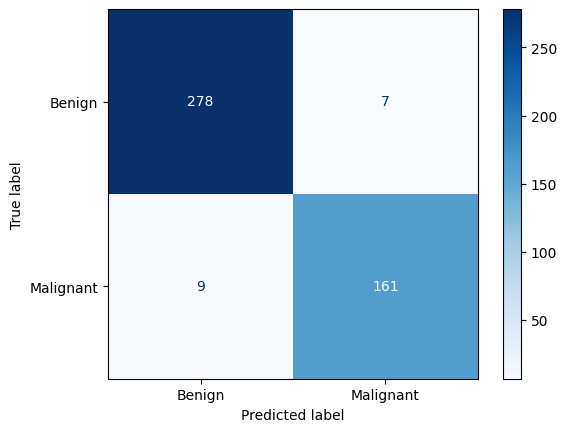

In [66]:
cross_val_confusion(stack3, X_train_filtered_top11, y_train_filtered_top11)

## Resumen de los modelos

In [67]:
models_dict={'Voting_Hard':voting_hard, 'Voting_Soft': voting_soft, 
             'Bagging_Trees':bagging_tree, 'Baggin_Logistic':bagging_LR, 
             'Random_Forest': rf, 'Extra_Trees':et, 
             'Boosting_Trees': xgb_tree, 'Boosting_logistic':adaboost_logistic,
             'RF+GB->LR':stack1, 'RF+LR+ET->Ridge':stack2, 'RF+ADA+GB->LR':stack3}

In [82]:
evaluate_multiple_models(models_dict, datasets, scoring=scoring, ordering='malignant_recall')

accuracy Mean  recall_macro Mean  \
Dataset           Model                                                 
All Features      Voting_Soft                0.982              0.979   
                  Voting_Hard                0.982              0.978   
                  Baggin_Logistic            0.985              0.979   
                  Boosting_logistic          0.976              0.972   
                  RF+LR+ET->Ridge            0.982              0.978   
                  Extra_Trees                0.971              0.968   
                  Boosting_Trees             0.958              0.955   
                  Random_Forest              0.954              0.950   
                  RF+GB->LR                  0.952              0.948   
                  RF+ADA+GB->LR              0.954              0.950   
                  Bagging_Trees              0.941              0.937   
Filtered Features Boosting_logistic          0.974              0.971   
                  Voting_Hard                0.978              0.973   
                  Voting_Soft                0.974              0.969   
                  Baggin_Logistic            0.976              0.971   
                  RF+LR+ET->Ridge            0.974              0.968   
                  RF+GB->LR                  0.956              0.953   
                  RF+ADA+GB->LR              0.958              0.955   
                  Boosting_Trees             0.963              0.957   
                  Extra_Trees                0.965              0.958   
                  Random_Forest              0.954              0.948   
                  Bagging_Trees              0.945              0.940   
Top 11 Important  Boosting_logistic          0.982              0.980   
                  Voting_Soft                0.978              0.974   
                  Baggin_Logistic            0.978              0.973   
                  Random_Forest              0.965              0.962   
                  Voting_Hard                0.974              0.968   
                  Boosting_Trees             0.965              0.961   
                  RF+GB->LR                  0.963              0.959   
                  RF+LR+ET->Ridge            0.976              0.970   
                  RF+ADA+GB->LR              0.960              0.957   
                  Bagging_Trees              0.954              0.950   
                  Extra_Trees                0.965              0.958   
Top 5 Important   Voting_Soft                0.960              0.955   
                  RF+ADA+GB->LR              0.958              0.954   
                  Voting_Hard                0.958              0.952   
                  Bagging_Trees              0.949              0.945   
                  Boosting_Trees             0.958              0.952   
                  RF+LR+ET->Ridge            0.956              0.951   
                  RF+GB->LR                  0.958              0.952   
                  Random_Forest              0.952              0.946   
                  Extra_Trees                0.952              0.946   
                  Baggin_Logistic            0.954              0.947   
                  Boosting_logistic          0.949              0.942   

                                     malignant_recall Mean  
Dataset           Model                                     
All Features      Voting_Soft                        0.965  
                  Voting_Hard                        0.959  
                  Baggin_Logistic                    0.959  
                  Boosting_logistic                  0.959  
                  RF+LR+ET->Ridge                    0.959  
                  Extra_Trees                        0.953  
                  Boosting_Trees                     0.941  
                  Random_Forest                      0.935  
                  RF+GB->LR                          0.935  
       

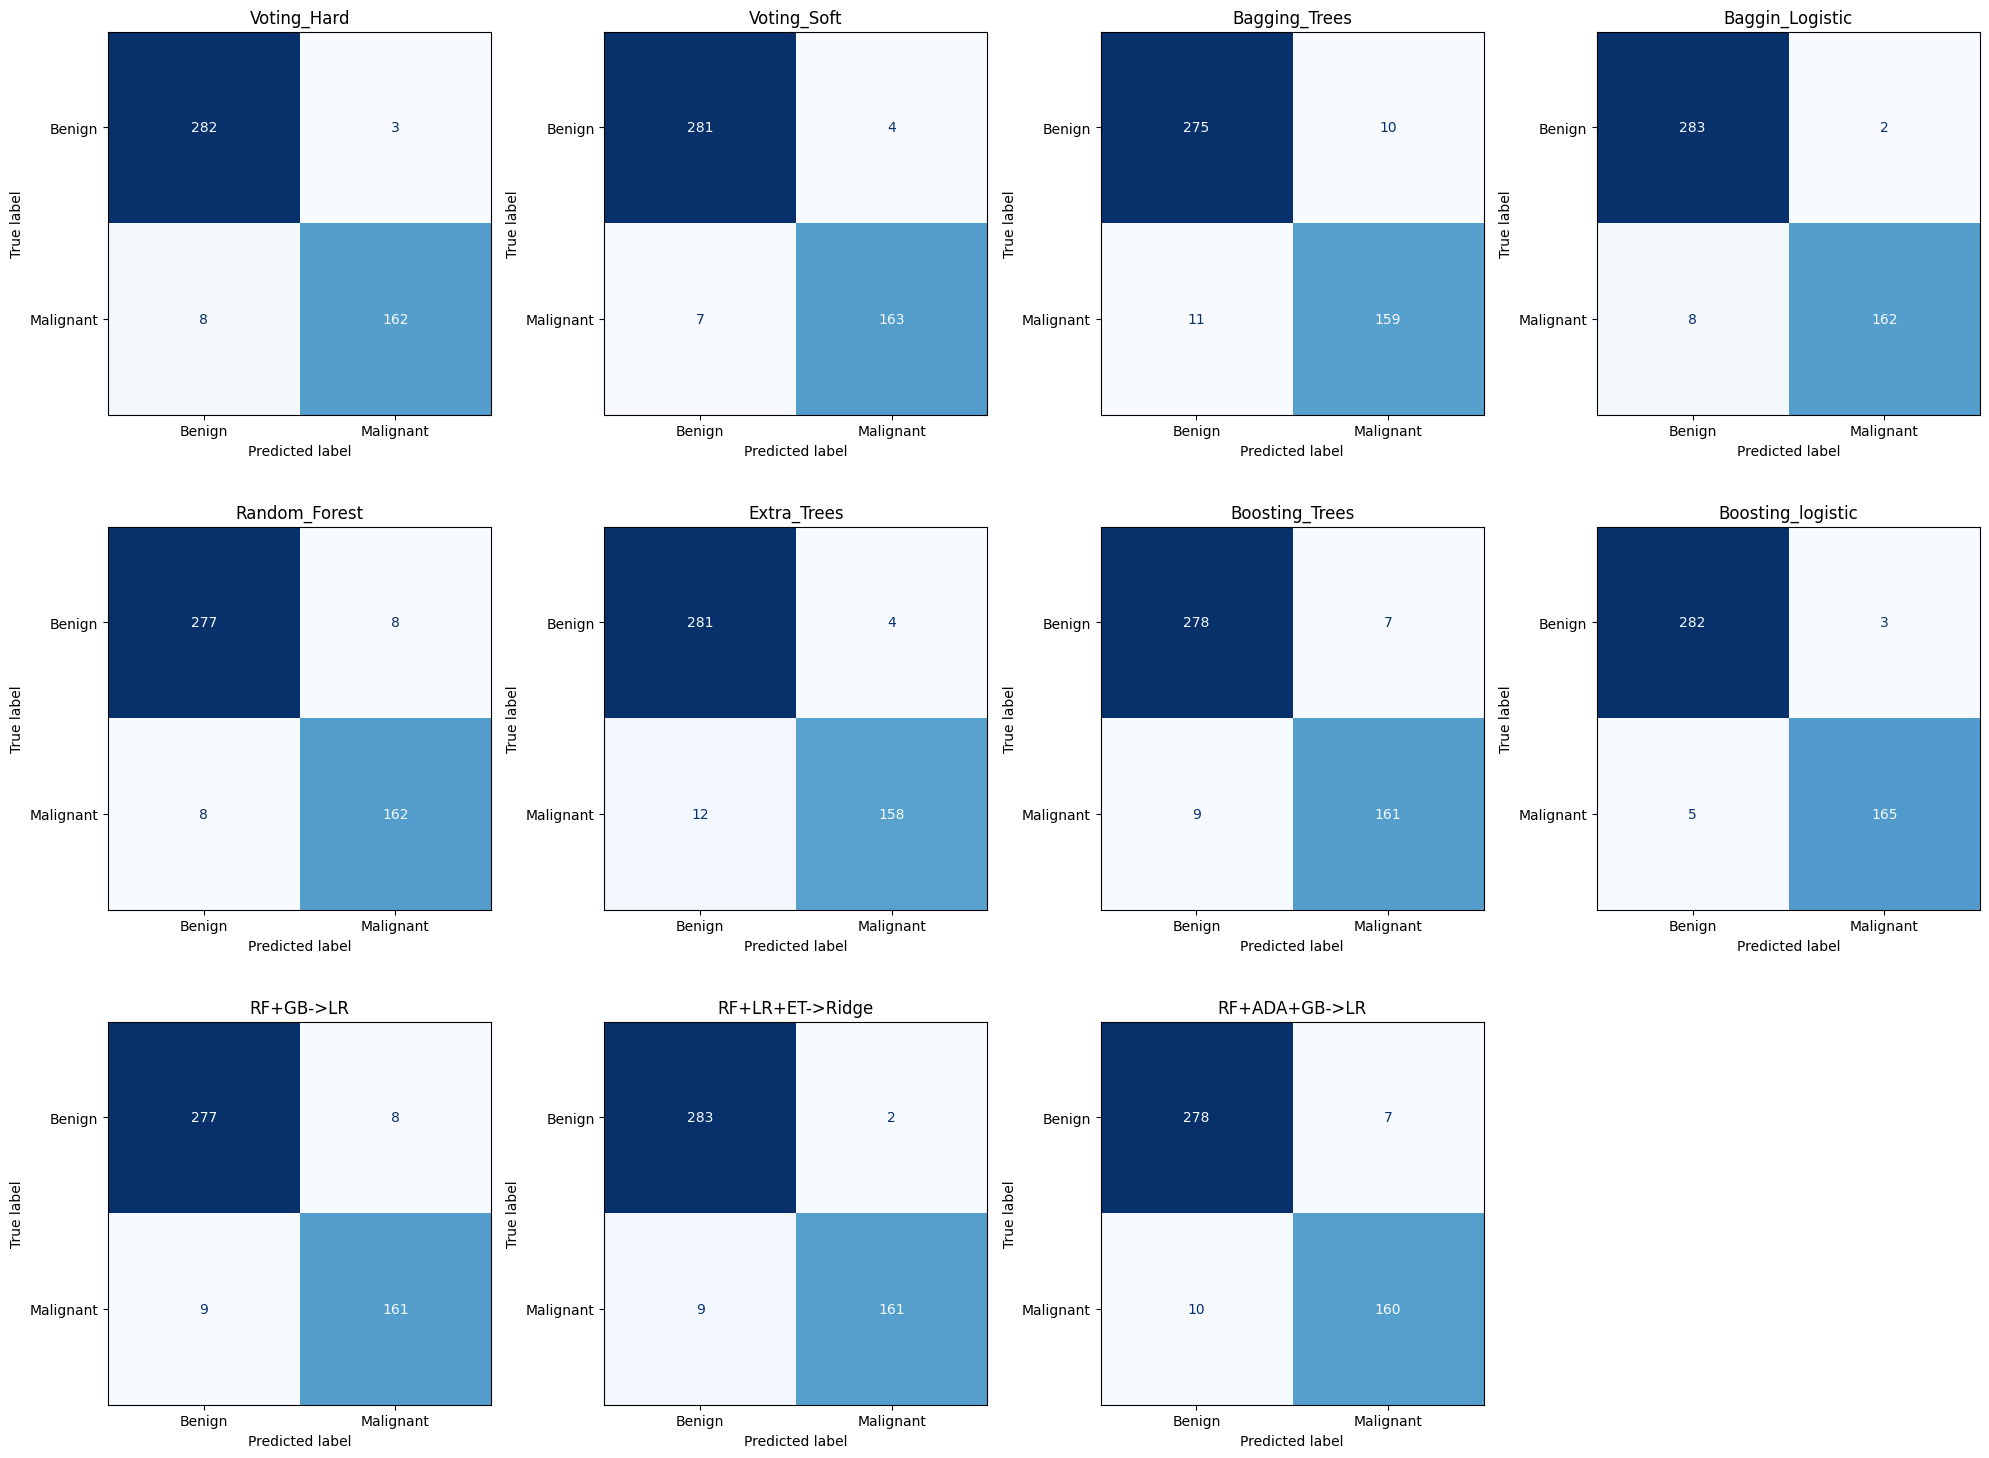

In [69]:
multiple_cross_val_confusions(models_dict, X_train_filtered_top11, y_train_filtered_top11)

# Afinación de hiperparámetros

In [71]:
X_test_filtered_top11=df_test_scaled[top_11_imp_features]
y_test_filtered_top11=df_test_scaled[target]

scoring = make_scorer(recall_score, pos_label=1)

In [72]:
estimators = [
    ('lr', LogisticRegression()),
    ('rf', RandomForestClassifier()),
    ('svc', SVC(probability=True))
]
voting_soft = VotingClassifier(estimators=estimators, voting='soft')


param_grid = {
    'lr__C': np.logspace(-4, 4, 10),
    'rf__n_estimators': [100, 200, 500],
    'rf__max_depth': [None, 10, 20],
    'svc__C': np.logspace(-3, 2, 6),
    'svc__gamma': ['scale', 'auto']
}


RS_results=perform_random_search(voting_soft, param_grid, X_test_filtered_top11, y_test_filtered_top11,scoring )



Performing RandomizedSearchCV for VotingClassifier...

Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best Score for VotingClassifier: 0.925
Best Parameters for VotingClassifier: {'svc__gamma': 'scale', 'svc__C': 0.01, 'rf__n_estimators': 500, 'rf__max_depth': None, 'lr__C': 2.782559402207126}


In [73]:
best_params=RS_results['best_params']
final_model = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(C=best_params['lr__C'])),
        ('rf', RandomForestClassifier(n_estimators=best_params['rf__n_estimators'], 
                                      max_depth=best_params['rf__max_depth'])),
        ('svc', SVC(probability=True, C=best_params['svc__C'], gamma=best_params['svc__gamma']))
    ],
    voting='soft'
)
# Fit the final model with the training data
final_model.fit(X_train_filtered_top11, y_train_filtered_top11)

y_pred = final_model.predict(X_test_filtered_top11)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Detailed classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

Test Accuracy: 0.9737
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98        72
           1       0.98      0.95      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



In [74]:
xgb_model = XGBClassifier(eval_metric='logloss', n_jobs=-1)

param_grid = {
    'max_depth': [1,2, 3, 4],
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [300, 500, 1000],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

scoring = make_scorer(recall_score, pos_label=1)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    verbose=1,
    n_jobs=-1
)
grid_search.fit(X_train_filtered_top11, y_train_filtered_top11)

# Best model
best_params = grid_search.best_params_
cv_score=grid_search.best_score_  

print(f"Best Params: {grid_search.best_params_}")
print(f"Cross-Validated score: {cv_score}")


Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best Params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 1000, 'subsample': 0.8}
Cross-Validated score: 0.9588235294117646


In [75]:
final_model = XGBClassifier(eval_metric='logloss', **best_params)
final_model.fit(X_train_filtered_top11, y_train_filtered_top11)

y_pred = final_model.predict(X_test_filtered_top11)

print(classification_report(y_test_filtered_top11, y_pred, target_names=["Benign", "Malignant"]))

              precision    recall  f1-score   support

      Benign       0.93      0.97      0.95        72
   Malignant       0.95      0.88      0.91        42

    accuracy                           0.94       114
   macro avg       0.94      0.93      0.93       114
weighted avg       0.94      0.94      0.94       114



Benign recall is easier to achieve if it has more consistent features
It’s possible that:

Benign cases have more regular, well-separated features

Malignant cases are more diverse or noisy, which makes them harder to catch all the time

So your model naturally finds it easier to classify benign samples with higher recall — even while prioritizing malignant during tuning.

# Interpretabilidad

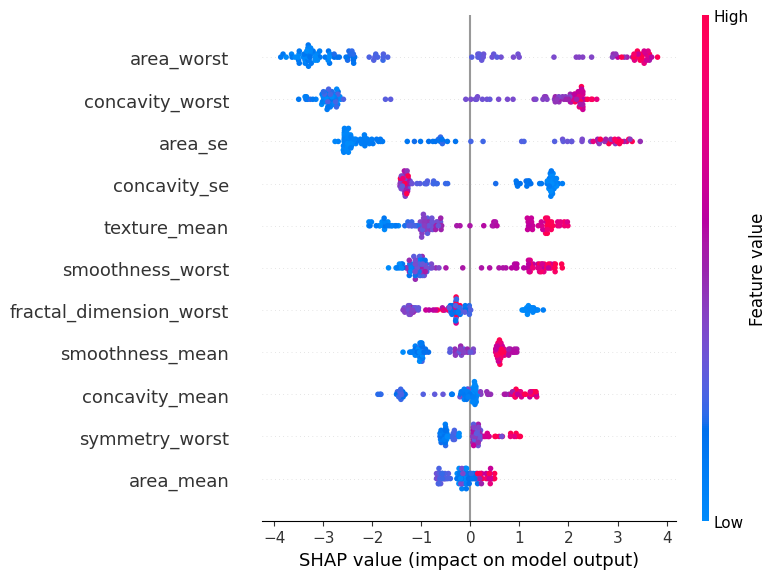

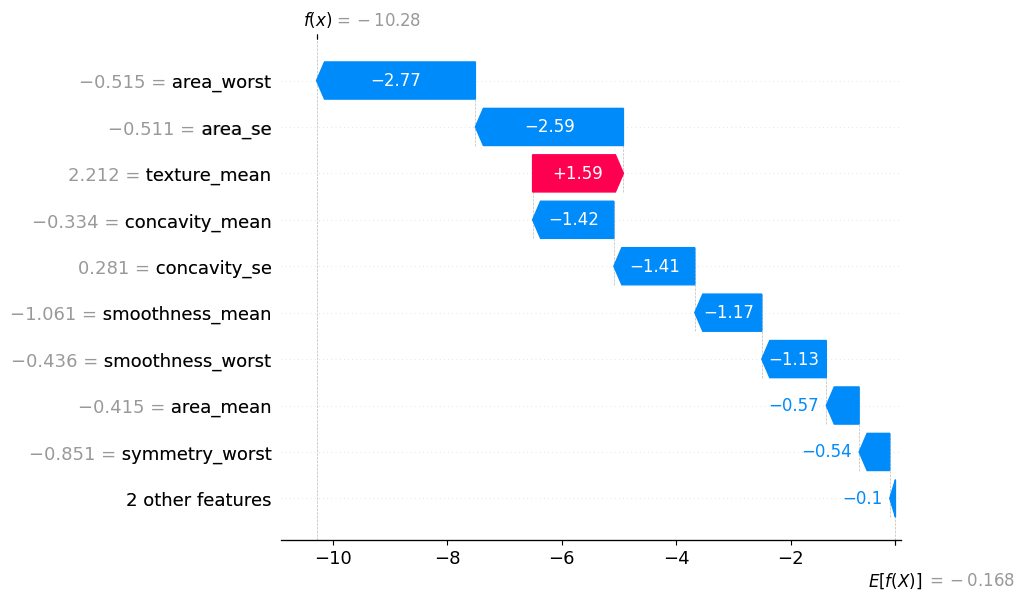

In [76]:
explainer = shap.Explainer(final_model)
shap_values = explainer(X_test_filtered_top11)

# Summary plot (Global feature importance)
shap.summary_plot(shap_values, X_test_filtered_top11)

# Waterfall plot for a specific company (first instance in test set)
shap.waterfall_plot(shap_values[0])

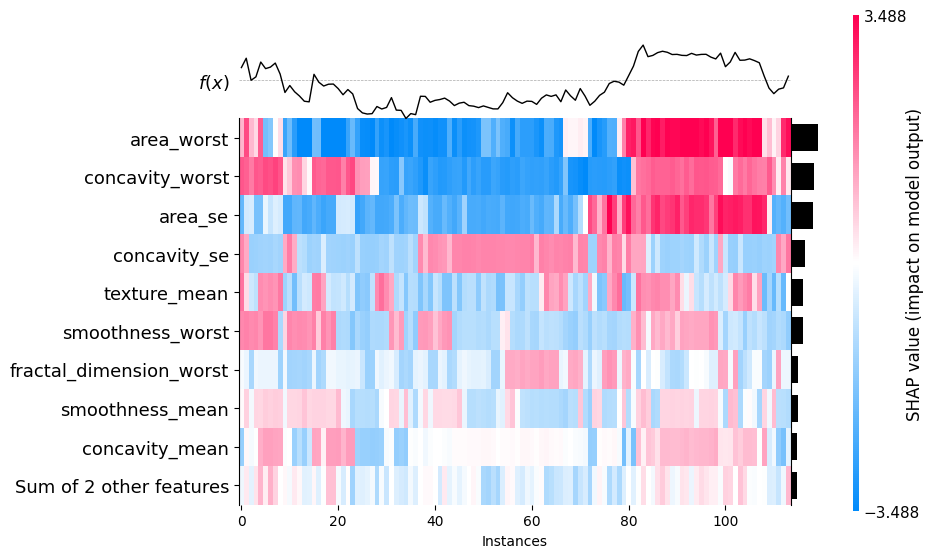

<Axes: xlabel='Instances'>

In [77]:
shap.plots.heatmap(shap_values)

In [78]:
force_plot=shap.plots.force(shap_values)
shap.save_html("shap_force_plot.html", force_plot)

print("SHAP force plot saved as 'shap_force_plot.html'. Open it in a browser.")

SHAP force plot saved as 'shap_force_plot.html'. Open it in a browser.


# Extra